# Make moment maps and overlays for galaxies in the MW cubes

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [5]:
# read in data cube

input_dir = '/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/'
#data_cube = 'NGC4808_combine_MW.fits'
#field = 'NGC4808'

data_cube = 'image.restored.i.SB34166.cube.MilkyWay.contsub.fits'
field = 'NGC5044_2A'

cube = SpectralCube.read('{}{}'.format(input_dir, data_cube))  # Open the FITS file for reading


In [31]:
c = SkyCoord('13:02:59 -17:24:10', unit=(u.hour, u.deg))
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (195.74583333, -17.40277778)>


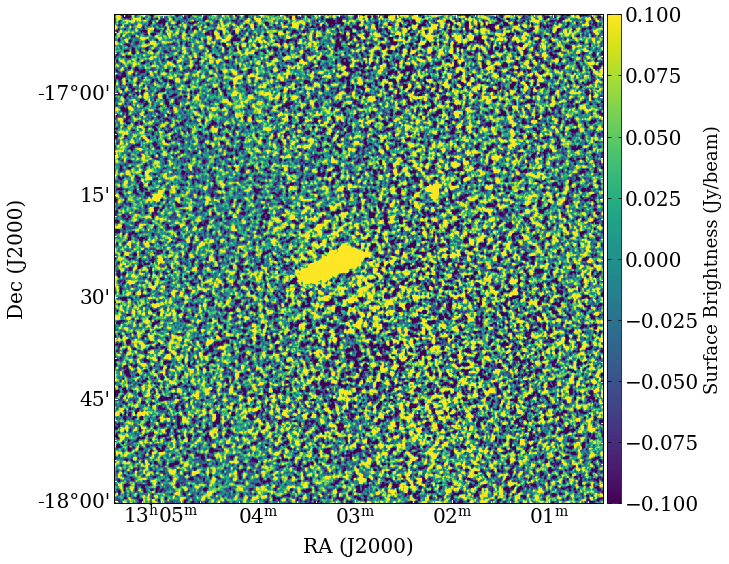

In [35]:
def make_moment_map(vel):
    cube_3 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
    subcube = cube_3.spectral_slab(vel[0]*u.km/u.s,vel[1]*u.km/u.s)
    moment_0_v3 = subcube.moment(order=0)

    f = aplpy.FITSFigure(moment_0_v3.hdu)  
    f.show_colorscale(cmap='viridis', vmin=-0.1, vmax=0.1)  
    f.recenter(c.ra.deg, c.dec.deg, radius=0.6)
    
    f.add_colorbar()
    f.colorbar.set_axis_label_text('Surface Brightness (Jy/beam)')
    f.colorbar.set_axis_label_font(size=18)
    f.colorbar.set_font(size=20, weight='medium', family='serif')
    
    f.axis_labels.set_font(size=20, weight='medium', family='serif')
    f.tick_labels.set_font(size=20, weight='medium', family='serif')
    f.save('./plots/moment_0_maps/{}_moment_{}-{}.png'.format(data_cube[:-5], vel[0],vel[1]), dpi=200) 

    hdul = fits.HDUList([moment_0_v3.hdu])
    hdul[0].header['BMIN']=0.5
    hdul[0].header['BMAJ']=0.5
    hdul[0].header['BPA']=0
    hdul.writeto('./moment_maps/group_mom_0_{}-{}kms.fits'.format(vel[0],vel[1]), overwrite=True)


make_moment_map([650,820])

197.0265916667 -18.09735 6.156042970658746
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff8e4d599d0>]]


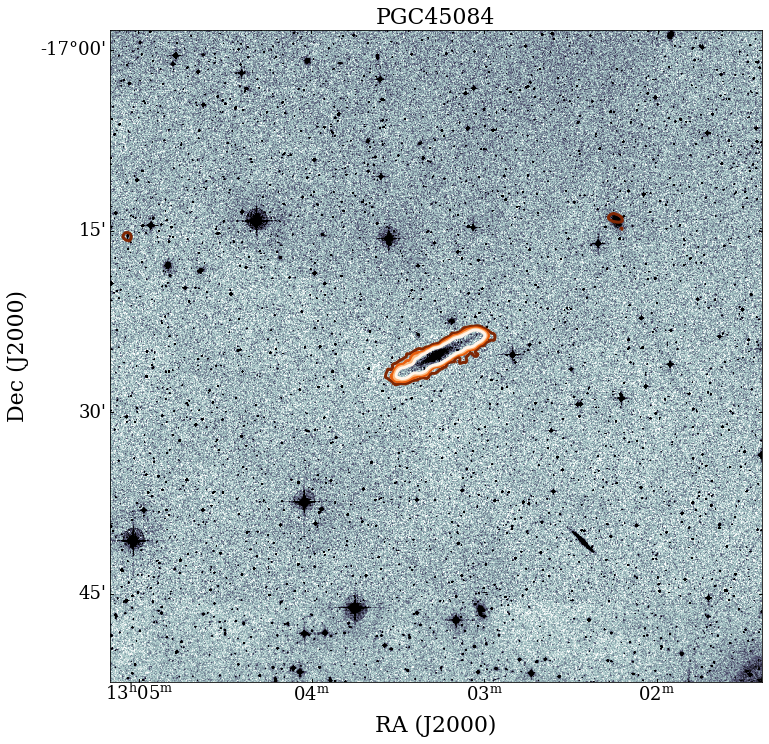

In [43]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

# def make_overlay(HI_image, name, view):

HI_image = './moment_maps/group_mom_0_650-820kms.fits'
name = 'PGC45084'
view = 0.9

hdulist_hi = fits.open('{}'.format(HI_image))
d = hdulist_hi[0].data
h = hdulist_hi[0].header
d = np.nan_to_num(d)
rms = np.sqrt(np.mean(np.square(d)))
print(h['CRVAL1'],h['CRVAL2'], np.max(d))

#get optical image
path = SkyView.get_images(position=name, width=view*u.deg, height=view*u.deg, survey=['DSS2 Red'], pixels=[900,900])

print(path)
if len(path) !=0:

    hdulist_opt = path[0]
    d2 = hdulist_opt[0].data
    h2 = hdulist_opt[0].header

    #fig = plt.figure(figsize=(18, 12))
    #ax = fig.add_subplot(111)
    #im = ax.imshow(d2, cmap='Oranges')

    #reproject HI data

    hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
    rms = np.sqrt(np.mean(np.square(hi_reprojected)))

    #plot data together

    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
    ax1.imshow(d2, cmap='bone_r', vmin=np.percentile(d2,10), vmax=np.percentile(d2,98))
    ax1.contour(hi_reprojected, cmap='Oranges_r', levels=[rms*2, rms*4, rms*6, rms*8], linewidths=3)
    #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
    #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
    #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
    #ax1.coords.grid(color='white')
    ax1.set_title(name, fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    fig.savefig('./plots/{}_overlay.png'.format(name), dpi=100)

